# Neural Network

In [67]:
import warnings
warnings.filterwarnings("ignore")

In [68]:
from pathlib import Path
import cvxpy as cp
import numpy as np
import pandas as pd
from statsmodels.regression.rolling import RollingOLS
from sklearn.metrics import r2_score
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import Input, Dense, Dot, BatchNormalization
from tensorflow.keras.models import Model

%config InlineBackend.figure_format = "retina"

In [69]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(
        self,
        n_splits=3,
        train_period_length=126,
        test_period_length=21,
        lookahead=0,
        date_idx="date",
        shuffle=False,
    ):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append(
                [train_start_idx, train_end_idx, test_start_idx, test_end_idx]
            )

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[
                (dates[self.date_idx] > days[train_start])
                & (dates[self.date_idx] <= days[train_end])
            ].index
            test_idx = dates[
                (dates[self.date_idx] > days[test_start])
                & (dates[self.date_idx] <= days[test_end])
            ].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self):
        return self.n_splits


In [70]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

In [71]:
def cache(func):
    def wrapped_func(*args, **kwargs):
        table_name = func.__name__.split("_")[-1]
        parquet_path = f"./data/{table_name}.parquet"
        try:
            table = pd.read_parquet(parquet_path)
        except FileNotFoundError:
            table = func(*args, **kwargs)
            table.to_parquet(parquet_path)
        return table

    return wrapped_func

def query(sql_stmt, params, wrds_username):
    import wrds

    with wrds.Connection(wrds_username=wrds_username) as db:
        data = db.raw_sql(sql_stmt, date_cols=["date"], params=params)
    return data

def get_crsp(permnos, wrds_username):
    sql_crsp = """
    SELECT
        date,
        permno,
        openprc AS open,
        askhi AS high,
        bidlo AS low,
        prc AS close,
        vol AS volume,
        ret,
        shrout
    FROM
        crsp.dsf
    WHERE
        permno IN %(permnos)s
        AND date >= '1994-01-01'
        AND date <= '2019-12-31'
    ORDER BY
        date, permno;
    """
    params = {"permnos": permnos}
    crsp = query(sql_crsp, params, wrds_username)
    # Fill missing close prices of permno 80539
    crsp.loc[crsp.permno == 80539, "close"] = crsp.loc[crsp.permno == 80539, "close"].fillna(method="ffill")
    # Fill other missing values
    crsp = crsp.fillna({"open": crsp.close,
        "high": crsp.close,
        "low": crsp.close,
        "volume": 0,
        "ret": 0})
    # Calculate market capitalization
    crsp["cap"] = crsp.close * crsp.shrout
    # Shift market capitalization to avoid look ahead bias
    crsp["cap"] = crsp.groupby("permno").cap.shift(1)
    # Calculate market capiticalization weight
    crsp["w_cap"] = crsp.groupby("date").cap.apply(lambda x: x / x.sum())
    # Convert certain data types to int64
    crsp = crsp.astype({"permno":"int",
                        "shrout": "int",
                        "volume":"int"})
    return crsp

def get_fama_french():
    """
    Get 3-factor and momentum data from Ken French data library.
    """
    import pandas_datareader as web

    # Transfrom from percentage to nominal value
    factor = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start="1994-01-01", end="2019-12-31")[0]/100
    momentum = web.DataReader("F-F_Momentum_Factor_daily", "famafrench", start="1994-01-01", end="2019-12-31")[0]/100
    # Merge into 4 factor model
    fama_french = pd.concat([factor, momentum], axis=1)
    fama_french = fama_french.rename(columns=lambda x: x.lower().strip().replace("-", "")).rename_axis(index=str.lower)
    return fama_french

In [72]:
path = Path("./data")
permno_path = path/"permno_selection.csv"
permnos = pd.read_csv(permno_path, dtype={"permno":"str"}).squeeze().pipe(tuple)
crsp = get_crsp(permnos, "iewaij")
fama_french = get_fama_french()

Loading library list...
Done


## Estimate Factor Exposure

In [73]:
portfolio = crsp.loc[crsp.date >= "1994-01-01", ["date", "permno", "ret"]].pivot(
    index="date", columns="permno", values="ret"
)
portfolio = portfolio.sub(fama_french.loc[portfolio.index, "rf"], axis=0)
factor = fama_french.loc[portfolio.index, ["mktrf", "smb", "hml", "mom"]].assign(alpha=1)
betas = []
for permno in portfolio:
    ret = portfolio[permno]
    res = RollingOLS(endog=ret, exog=factor, window=756).fit(params_only=True)
    params = res.params
    params["resid"] = ret - factor.mul(params).sum(1)
    params["excess"] = ret - factor.mktrf * params.mktrf
    params["permno"] = permno
    betas.append(params)
beta = pd.concat(betas).reset_index().dropna()

## Estimate Price Trend

In [74]:
ret = crsp.pivot(index="date", columns="permno", values="ret")
logret = np.log(ret+1)
# 1-month cumulative return
mom_1m = logret.rolling(21).sum()
# 11-month cumulative returns ending 1-month before
mom_12m = logret.shift(21).rolling(11*21).sum()
# Cumulative return from months t-6 to t-1 minus months t-12 to t-7.
mom_6m = logret.shift(21).rolling(5*21).sum()
mom_12m_6m = logret.shift(6*21).rolling(5*21).sum()
chmom = mom_6m - mom_12m_6m
# Max daily returns from calendar month t-1
maxret = logret.rolling(21).max()
# Cumulative returns months t-36 to t-13
mom_36m = logret.shift(12*21).rolling(24*21).sum()

## Estimate Liquidity

In [75]:
vol = crsp.pivot(index="date", columns="permno", values="volume")
shrout = crsp.pivot(index="date", columns="permno", values="shrout")
close = crsp.pivot(index="date", columns="permno", values="close") 
# Average monthly trading volume for most recent three months divided by number of shares
turn = vol.shift(21).mean().div(shrout)
# Monthly std dev of daily share turnover
turn_std = vol.div(shrout).rolling(21).std()
# Natural log of market cap
logcap = np.log(close) + np.log(shrout)
# Natural log of trading volume times price per share from month t-2
dv = vol.mul(close)
dolvol = np.log(dv.shift(21).rolling(21).mean())
# Average of daily (absolute return / dollar volume)
ill = ret.abs().div(dv)

## Estimate Risk

In [76]:
# Standard dev of daily returns from month t-1
retvol = ret.rolling(21).std()
# Market beta
mktrf = beta.pivot(index="date", columns="permno", values="mktrf")
# Market beta squared
mktrf_sq = mktrf.pow(2)
# Idiosyncratic return volatility
resid = beta.pivot(index="date", columns="permno", values="resid")
idovol = resid.rolling(756).std()

## Prepare Data

In [77]:
def combine_factor(**kwargs):
    from sklearn.preprocessing import quantile_transform

    characteristics = [
        "mom_1m",
        "mom_12m",
        "chmom",
        "maxret",
        "mom_36m",
        "turn",
        "turn_std",
        "logcap",
        "dolvol",
        "ill",
        "retvol",
        "mktrf",
        "mktrf_sq",
        "idovol",
    ]

    factor = pd.DataFrame(
        {
            name: factor.resample("W-FRI").last().stack()
            for name, factor in kwargs.items()
        }
    ).loc["2000-01-01":]

    factor.loc[:, characteristics] = (
        factor.loc[:, characteristics]
        .groupby("date")
        .apply(
            lambda x: pd.DataFrame(
                quantile_transform(x, copy=True, n_quantiles=x.shape[0]),
                columns=characteristics,
                index=x.index.get_level_values("permno"),
            )
        )
        .mul(2)
        .sub(1)
    )
    factor = factor.groupby("date").transform(lambda x: x.fillna(x.mean()))
    return factor


In [78]:
factor = combine_factor(
    mom_1m=mom_1m,
    mom_12m=mom_12m,
    chmom=chmom,
    maxret=maxret,
    mom_36m=mom_36m,
    turn=turn,
    turn_std=turn_std,
    logcap=logcap,
    dolvol=dolvol,
    ill=ill,
    retvol=retvol,
    mktrf=mktrf,
    mktrf_sq=mktrf_sq,
    idovol=idovol,
    ret=ret
)
ret_5d = np.exp(logret.resample("W-FRI").sum().stack().shift(-1)) - 1
X = factor["2000-01-01":"2012-12-31"] 
y = ret_5d["2000-01-01":"2012-12-31"]

In [79]:
n_characteristics = 14
n_tickers = 50

In [80]:
def make_model(hidden_units, n_factors):
    input_factor = Input((n_tickers,), name='input_factor')
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)
    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)
    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])
    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

In [81]:
def get_train_valid_data(X, y, train_idx, val_idx):
    X_train = X.iloc[train_idx]
    X_val = X.iloc[val_idx]
    X1_train = X_train.drop(columns="ret").to_numpy().reshape(-1, n_tickers, n_characteristics)
    X1_val = X_val.drop(columns="ret").to_numpy().reshape(-1, n_tickers, n_characteristics)
    X2_train = X_train.loc[:, "ret"].unstack("permno")
    X2_val = X_val.loc[:, "ret"].unstack("permno")
    y_train = y.iloc[train_idx].unstack("permno")
    y_val = y.iloc[val_idx].unstack("permno")
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

In [82]:
n_characteristics = 14
n_tickers = 50
n_factors = 6
units = 16
batch_size = 32
epoch = 100

In [83]:
cv = MultipleTimeSeriesCV(n_splits=7, 
                          train_period_length=6*52,
                          test_period_length=1*52)

In [84]:
predictions = []
for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(X, y, train_idx, val_idx)
    model = make_model(n_factors=n_factors, hidden_units=units)
    model.fit([X1_train, X2_train],
        y_train,
        batch_size=batch_size,
        epochs=epoch,
        verbose=0,
        shuffle=True)
    
    predictions.append(pd.Series(model.predict([X1_val, X2_val]).reshape(-1), index=y_val.stack().index))

2022-03-29 12:01:06.678534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-29 12:01:14.986312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-29 12:01:15.384588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-29 12:01:23.631350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-29 12:01:24.000498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-29 12:01:32.105834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-29 12:01:32.490777: I tensorflow/core/grappler/optimizers/cust

## Backtest

In [85]:
y_pred = pd.concat(predictions).sort_index()
y_val = ret_5d[y_pred.index]
r2_score(y_val, y_pred)

-0.05012999687810016

In [86]:
w_optimal = pd.Series(None, index=y_pred.index)
w_caps = crsp[["date", "permno", "w_cap"]].groupby([pd.Grouper(key="date", freq="W-FRI"), "permno"]).w_cap.last()
unique_dates = y_pred.index.get_level_values("date").unique()
for date in tqdm(unique_dates):
    w_cap = w_caps[date].to_numpy()
    mu = y_pred[date].to_numpy()
    Sigma = crsp[crsp.date <= date].pivot(index="date", columns="permno", values="ret").tail(252).cov().to_numpy()
    Beta = X[X.index.get_level_values("date") == date].drop(columns="ret")
    # The shape of the variables should be as follows
    assert Sigma.shape == (50, 50)
    assert Beta.shape == (50, 14)
    assert mu.shape == (50,)
    assert w_cap.shape == (50,)
    # w is the weights for 50 stocks
    w = cp.Variable(50)
    # ret is expected return times weights (Does the return need to be adjusted with risk free rate?)
    ret = mu.T@w 
    # risk is cov matrix with weights in quadratic form, w.T@Sigma@w
    risk = cp.quad_form(w, Sigma)
    # gamma is the risk aversion parameter
    gamma = cp.Parameter(nonneg=True)
    # Say gamma is 0, we maximize return, this can be adjusted
    gamma.value = 0
    # Classical Markowitz portfolio optimization (Does risk need to be sqrt or not?)
    obj = cp.Maximize(ret - gamma*risk)
    # Constraints
    constraints = [w >= 0, # Long-only
                cp.sum(w) == 1, # Sum of weights equal to 1
                #Beta.T @ ((w - w_cap) / w_cap) <= 0.05, # Factor exposure deviation <= 0.05
                #Beta.T @ ((w - w_cap) / w_cap) >= -0.05, # Factor exposure deviation >= -0.05
                (w - w_cap) / w_cap <= 0.1, # Weight deviation <= 0.1
                (w - w_cap) / w_cap >= -0.1, # Weight deviation >= -0.1
                (1 + mu.T) @ ((w - w_cap) / w_cap) >= -0.01, # Drawdown relative to benchmark >= -0.01
                ]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver="ECOS")
    w_optimal[date] = np.asarray(w.value).flatten()

100%|██████████| 364/364 [00:15<00:00, 23.41it/s]


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2012-12-31  2012-12-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          48.08%      51.68%
CAGR﹪                     5.77%       6.13%

Sharpe                     0.43        0.45
Smart Sharpe               0.37        0.39
Sortino                    0.61        0.64
Smart Sortino              0.53        0.56
Sortino/√2                 0.43        0.45
Smart Sortino/√2           0.37        0.39
Omega                      1.09        1.09

Max Drawdown               -38.86%     -39.22%
Longest DD Days            1234        1235
Volatility (ann.)          16.36%      16.35%
R^2                        1.0         1.0
Calmar                     0.15        0.16
Skew                       0.47        0.45
Kurtosis                   14.63       14

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-11,2009-03-09,2011-04-28,1234,-38.863935,-34.431201
2,2011-05-20,2011-08-10,2011-12-20,214,-10.951177,-8.165685
3,2012-10-19,2012-11-15,2012-12-31,73,-6.542169,-6.334602
4,2007-05-21,2007-07-31,2007-09-18,120,-5.994616,-5.966203
5,2012-04-03,2012-06-01,2012-06-29,87,-4.965457,-4.737554


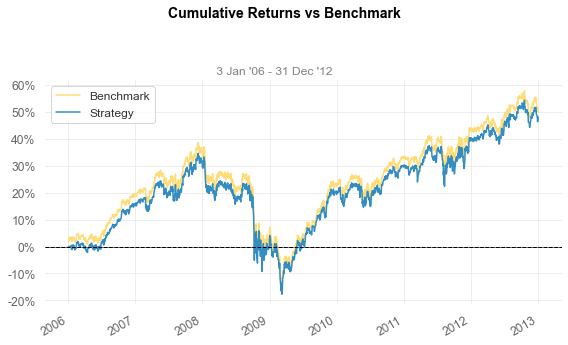

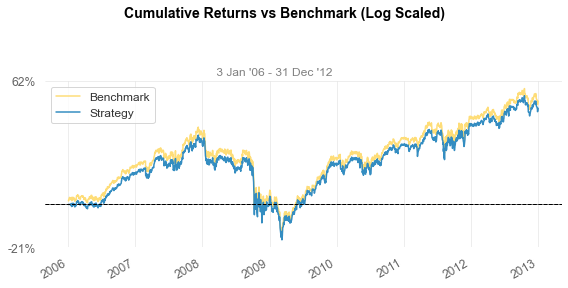

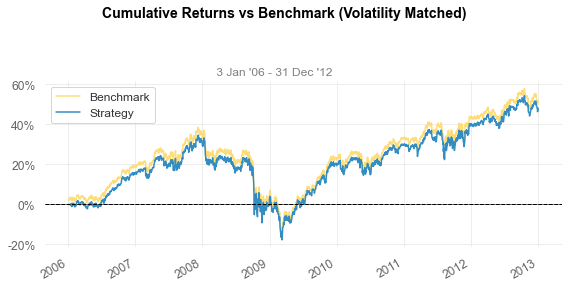

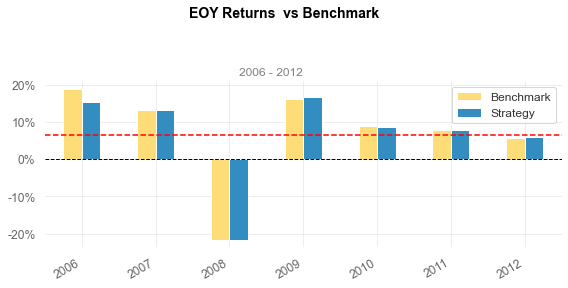

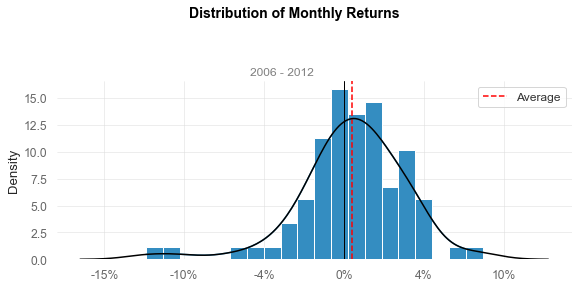

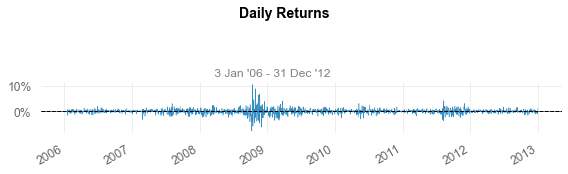

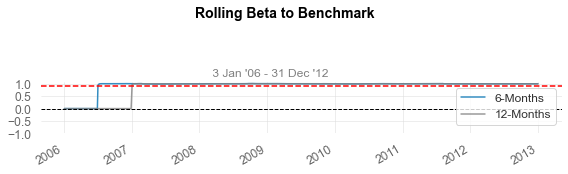

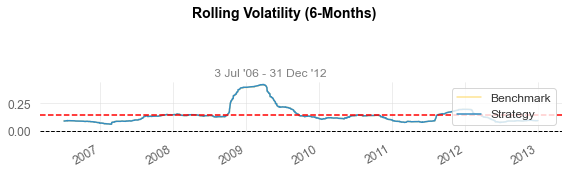

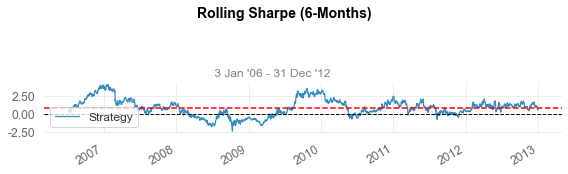

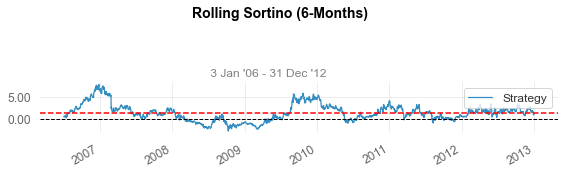

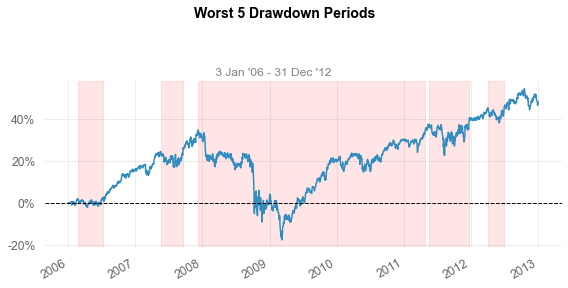

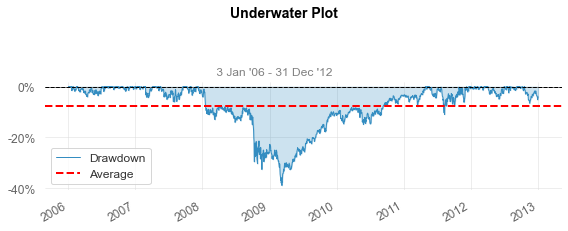

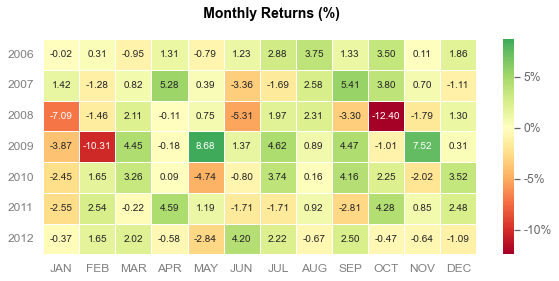

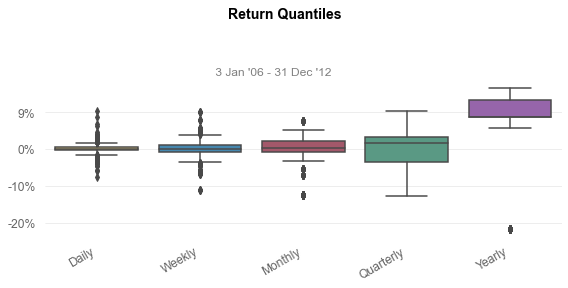

In [87]:
ret = crsp[["date", "permno", "ret", "w_cap"]].set_index(["date", "permno"]).loc["2006-01-01":"2012-12-31"]
ret["w_optimal"] = w_optimal
ret["w_optimal"] = ret.groupby("permno").w_optimal.fillna(method="ffill")
ret["w_optimal"] = ret.groupby("permno").w_optimal.shift(1)
bnch_ret = (ret.ret * ret.w_cap).groupby("date").sum()
bt_ret = (ret.ret * ret.w_optimal).groupby("date").sum()
qs.reports.full(bt_ret, bnch_ret)